In [1]:
!python3 -m pip install --upgrade setuptools pip
!python3 -m pip install nvidia-pyindex
#!python3 -m pip install --upgrade nvidia-tensorrt
!python3 -m pip install nvidia-tensorrt==7.2.* --index-url https://pypi.ngc.nvidia.com

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 31.2 MB/s 
     |████████████████████████████████| 2.1 MB 52.0 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-pyindex: filename=nvidia_pyindex-1.0.

In [2]:
import tensorrt
print(tensorrt.__version__)
assert tensorrt.Builder(tensorrt.Logger())

7.2.3.4


In [3]:
!sudo apt install libnvinfer* libnvinfer-dev
!pip install torch2trt-unofficial
#%cd ..
!sudo pip3 install tqdm cython pycocotools
!sudo apt-get install python3-matplotlib
!git clone https://github.com/NVIDIA-AI-IOT/trt_pose
%cd trt_pose 
!sudo apt-get install libprotobuf* protobuf-compiler ninja-build
!sudo python3 setup.py install
!python3 setup.py build_ext --inplace


Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libnvinfer-dev' for glob 'libnvinfer*'
Note, selecting 'libnvinfer-plugin-dev' for glob 'libnvinfer*'
Note, selecting 'libnvinfer4' for glob 'libnvinfer*'
Note, selecting 'libnvinfer5' for glob 'libnvinfer*'
Note, selecting 'libnvinfer6' for glob 'libnvinfer*'
Note, selecting 'libnvinfer7' for glob 'libnvinfer*'
Note, selecting 'libnvinfer8' for glob 'libnvinfer*'
Note, selecting 'libnvinfer-plugin6' for glob 'libnvinfer*'
Note, selecting 'libnvinfer-plugin7' for glob 'libnvinfer*'
Note, selecting 'libnvinfer-plugin8' for glob 'libnvinfer*'
Note, selecting 'libnvinfer5' instead of 'libnvinfer4'
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cuda-cudart-10-2 cuda-license-10-2
The following NEW packages will be installed:
  cuda-cu

In [4]:
import json
import trt_pose.coco

!wget -q --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XYDdCUdiF2xxx4rznmLb62SdOUZuoNbd' -O 'resnet18_baseline_att_224x224_A_epoch_249.pth'
%cd ..

import trt_pose.models
import torch
from torch2trt import torch2trt
from torch2trt import TRTModule
import cv2
import torchvision.transforms as transforms
import PIL.Image
from trt_pose.draw_objects import DrawObjects
from trt_pose.parse_objects import ParseObjects


with open('trt_pose/tasks/human_pose/human_pose.json', 'r') as f:
    human_pose = json.load(f)

topology = trt_pose.coco.coco_category_to_topology(human_pose)

num_parts = len(human_pose['keypoints'])
num_links = len(human_pose['skeleton'])

model = trt_pose.models.resnet18_baseline_att(num_parts, 2 * num_links).cuda().eval()
MODEL_WEIGHTS = 'trt_pose/resnet18_baseline_att_224x224_A_epoch_249.pth'
WIDTH = 224
HEIGHT = 224
data = torch.zeros((1, 3, HEIGHT, WIDTH)).cuda()


model.load_state_dict(torch.load(MODEL_WEIGHTS))
model_trt = torch2trt(model, [data], fp16_mode=True, max_workspace_size=1<<25)
OPTIMIZED_MODEL = 'resnet18_baseline_att_224x224_A_epoch_249_trt.pth'

torch.save(model_trt.state_dict(), OPTIMIZED_MODEL)
model_trt = TRTModule()
model_trt.load_state_dict(torch.load(OPTIMIZED_MODEL))

mean = torch.Tensor([0.485, 0.456, 0.406]).cuda()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda()
device = torch.device('cuda')

parse_objects = ParseObjects(topology)
draw_objects = DrawObjects(topology)



/content


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [5]:
def preprocess(image):
    global device
    device = torch.device('cuda')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = PIL.Image.fromarray(image)
    print(image)
    image = transforms.functional.to_tensor(image).to(device)
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]

def execute(image):
    data = preprocess(image)
    cmap, paf = model_trt(data)
    cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
    counts, objects, peaks = parse_objects(cmap, paf)#, cmap_threshold=0.15, link_threshold=0.15)
    draw_objects(image, counts, objects, peaks)
    return image

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F249685FF90>


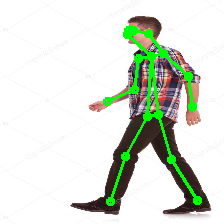

In [6]:
from google.colab.patches import cv2_imshow
image=cv2.imread('img.jpg')
image=cv2.resize(image, (224,224))
#cv2_imshow(image)
image=execute(image)
cv2_imshow(image)
